In [49]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# Define the path to the data folder
data_folder = "./lego_parts"

In [3]:
# Define the list of available classes (part numbers)
classes = os.listdir(data_folder)
classes.remove('.DS_Store')

In [30]:
# Save the classes list to a separate file using pickle
classes_file = "./classes.pkl"
with open(classes_file, 'wb') as file:
    pickle.dump(classes, file)

In [ ]:
# Function to create class mapping from classes list
def create_class_mapping(classes):
    class_mapping = {idx: class_name for idx, class_name in enumerate(classes)}
    return class_mapping

# Create the class mapping
class_mapping = create_class_mapping(classes)

In [ ]:
# Custom function to map model predictions to class labels
def map_predictions(predictions):
    predicted_labels = [class_mapping[np.argmax(pred)] for pred in predictions]
    return predicted_labels

In [ ]:
# Write the class mapping to a CSV file
csv_file = "./class_mapping.csv"
with open(csv_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Index', 'Class'])
    for index, class_name in enumerate(classes):
        csv_writer.writerow([index, class_name])

In [4]:
# Create image datasets using TensorFlow's image_dataset_from_directory
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_folder,
  labels="inferred",
  label_mode="int",
  class_names=classes,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(64, 64),
  batch_size=32)


train_ds,test_ds=tf.keras.utils.split_dataset(
    train_ds, left_size=None, right_size=.15,
)

Found 28000 files belonging to 7 classes.
Using 22400 files for training.
Using 5600 files for validation.


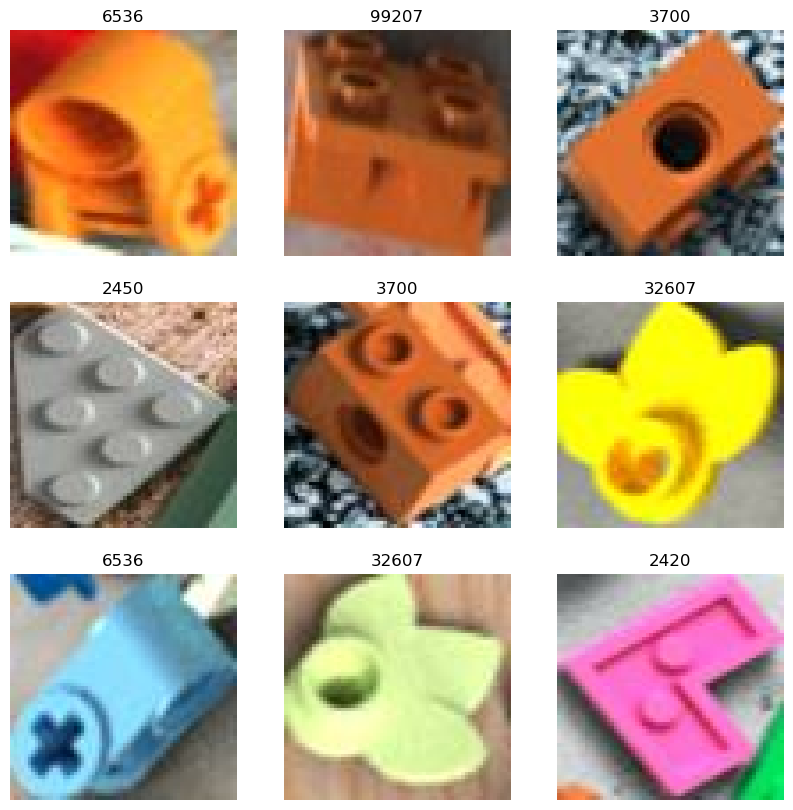

In [5]:
# Plot the first 9 images in the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")
plt.show()

In [6]:
# Normalize the pixel values of images to [0, 1]
normalization_layer = layers.Rescaling(1./255)

In [7]:
# Define our custom model architecture
our_model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(64, 64, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(len(classes), activation='softmax')
])

In [8]:
# Custom callback to save training history on each batch
class BatchHistorySaverCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.batch_history = []

    def on_batch_end(self, batch, logs=None):
        batch_logs = logs.copy()
        batch_logs['batch'] = batch
        self.batch_history.append(batch_logs)

# Define train and evaluate functions with saving
def train_and_evaluate_model(model_name, model):
    print(f"Training and evaluating {model_name}...")
    model = tf.keras.models.clone_model(model)
    model.compile(optimizer=adam,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    checkpoint_path = f"./best/best_model_{model_name}.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    batch_history_saver = BatchHistorySaverCallback()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, checkpoint_callback, batch_history_saver]
    )

    eval_results = model.evaluate(test_ds)

    trained_models[model_name] = {
        "model": model,
        "train_accuracy": history.history['accuracy'][-1],
        "val_accuracy": history.history['val_accuracy'][-1],
        "test_accuracy": eval_results[1],
        "train_loss": history.history['loss'][-1],
        "val_loss": history.history['val_loss'][-1],
        "test_loss": eval_results[0],
        "history": history.history,  # Save the training history
        "batch_history": batch_history_saver.batch_history  # Save the batch history
    }

    model.save(f"./models/trained_model_{model_name}.h5")

In [9]:
# Define the models list
models = [
    ("Our model", our_model),
    ("VGG16", tf.keras.applications.VGG16(weights=None, input_shape=(64, 64, 3), classes=len(classes))),
    ("DenseNet121", tf.keras.applications.DenseNet121(weights=None, input_shape=(64, 64, 3), classes=len(classes))),
    ("DenseNet169", tf.keras.applications.DenseNet169(weights=None, input_shape=(64, 64, 3), classes=len(classes))),
    ("DenseNet201", tf.keras.applications.DenseNet201(weights=None, input_shape=(64, 64, 3), classes=len(classes))),
]

In [10]:
# Define the number of epochs and the Adam optimizer
epochs = 100
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Define trained_models dictionary
trained_models = {}

for model_name, model in models:
    train_and_evaluate_model(model_name, model)

Training and evaluating Our model...
Epoch 1/100
594/595 [============================>.] - ETA: 0s - loss: 1.7785 - accuracy: 0.2706
Epoch 1: val_accuracy improved from -inf to 0.50196, saving model to ./best/best_model_Our model.h5
595/595 [==============================] - 12s 19ms/step - loss: 1.7778 - accuracy: 0.2708 - val_loss: 1.5033 - val_accuracy: 0.5020
Epoch 2/100
  7/595 [..............................] - ETA: 12s - loss: 1.5413 - accuracy: 0.3839

/Users/jakubsutowski/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


593/595 [============================>.] - ETA: 0s - loss: 1.3105 - accuracy: 0.5003
Epoch 2: val_accuracy improved from 0.50196 to 0.57643, saving model to ./best/best_model_Our model.h5
595/595 [==============================] - 11s 19ms/step - loss: 1.3102 - accuracy: 0.5005 - val_loss: 1.2567 - val_accuracy: 0.5764
Epoch 3/100
594/595 [============================>.] - ETA: 0s - loss: 1.1153 - accuracy: 0.5878
Epoch 3: val_accuracy improved from 0.57643 to 0.60964, saving model to ./best/best_model_Our model.h5
595/595 [==============================] - 11s 19ms/step - loss: 1.1150 - accuracy: 0.5879 - val_loss: 1.1478 - val_accuracy: 0.6096
Epoch 4/100
593/595 [============================>.] - ETA: 0s - loss: 1.0024 - accuracy: 0.6328
Epoch 4: val_accuracy improved from 0.60964 to 0.62518, saving model to ./best/best_model_Our model.h5
595/595 [==============================] - 11s 18ms/step - loss: 1.0020 - accuracy: 0.6329 - val_loss: 1.0852 - val_accuracy: 0.6252
Epoch 5/100
5

Epoch 1/100
  6/595 [..............................] - ETA: 1:15 - loss: 2.2700 - accuracy: 0.1510WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0406s vs `on_train_batch_end` time: 0.0729s). Check your callbacks.


595/595 [==============================] - ETA: 0s - loss: 1.9482 - accuracy: 0.1505
Epoch 1: val_accuracy improved from -inf to 0.14071, saving model to ./best/best_model_VGG16.h5
595/595 [==============================] - 82s 137ms/step - loss: 1.9482 - accuracy: 0.1505 - val_loss: 1.9499 - val_accuracy: 0.1407
Epoch 2/100
595/595 [==============================] - ETA: 0s - loss: 1.9086 - accuracy: 0.1772
Epoch 2: val_accuracy improved from 0.14071 to 0.24071, saving model to ./best/best_model_VGG16.h5
595/595 [==============================] - 82s 138ms/step - loss: 1.9086 - accuracy: 0.1772 - val_loss: 1.6944 - val_accuracy: 0.2407
Epoch 3/100
595/595 [==============================] - ETA: 0s - loss: 1.2731 - accuracy: 0.4508
Epoch 3: val_accuracy improved from 0.24071 to 0.57589, saving model to ./best/best_model_VGG16.h5
595/595 [==============================] - 97s 163ms/step - loss: 1.2731 - accuracy: 0.4508 - val_loss: 1.0175 - val_accuracy: 0.5759
Epoch 4/100
595/595 [====

Epoch 1/100
595/595 [==============================] - ETA: 0s - loss: 1.4132 - accuracy: 0.4436
Epoch 1: val_accuracy improved from -inf to 0.52696, saving model to ./best/best_model_DenseNet121.h5
595/595 [==============================] - 94s 142ms/step - loss: 1.4132 - accuracy: 0.4436 - val_loss: 1.2115 - val_accuracy: 0.5270
Epoch 2/100
595/595 [==============================] - ETA: 0s - loss: 0.9407 - accuracy: 0.6408
Epoch 2: val_accuracy improved from 0.52696 to 0.61643, saving model to ./best/best_model_DenseNet121.h5
595/595 [==============================] - 81s 136ms/step - loss: 0.9407 - accuracy: 0.6408 - val_loss: 1.0276 - val_accuracy: 0.6164
Epoch 3/100
595/595 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.7646
Epoch 3: val_accuracy improved from 0.61643 to 0.71446, saving model to ./best/best_model_DenseNet121.h5
595/595 [==============================] - 80s 135ms/step - loss: 0.6582 - accuracy: 0.7646 - val_loss: 0.7859 - val_accuracy: 0.

Epoch 1/100
595/595 [==============================] - ETA: 0s - loss: 1.4687 - accuracy: 0.4173
Epoch 1: val_accuracy improved from -inf to 0.49250, saving model to ./best/best_model_DenseNet169.h5
595/595 [==============================] - 138s 204ms/step - loss: 1.4687 - accuracy: 0.4173 - val_loss: 1.2870 - val_accuracy: 0.4925
Epoch 2/100
595/595 [==============================] - ETA: 0s - loss: 0.9930 - accuracy: 0.6198
Epoch 2: val_accuracy improved from 0.49250 to 0.63607, saving model to ./best/best_model_DenseNet169.h5
595/595 [==============================] - 114s 191ms/step - loss: 0.9930 - accuracy: 0.6198 - val_loss: 0.9689 - val_accuracy: 0.6361
Epoch 3/100
595/595 [==============================] - ETA: 0s - loss: 0.7028 - accuracy: 0.7422
Epoch 3: val_accuracy improved from 0.63607 to 0.64446, saving model to ./best/best_model_DenseNet169.h5
595/595 [==============================] - 117s 196ms/step - loss: 0.7028 - accuracy: 0.7422 - val_loss: 1.0098 - val_accuracy:

Epoch 1/100
595/595 [==============================] - ETA: 0s - loss: 1.4028 - accuracy: 0.4498
Epoch 1: val_accuracy improved from -inf to 0.49500, saving model to ./best/best_model_DenseNet201.h5
595/595 [==============================] - 184s 265ms/step - loss: 1.4028 - accuracy: 0.4498 - val_loss: 1.4716 - val_accuracy: 0.4950
Epoch 2/100
595/595 [==============================] - ETA: 0s - loss: 0.9559 - accuracy: 0.6370
Epoch 2: val_accuracy improved from 0.49500 to 0.67429, saving model to ./best/best_model_DenseNet201.h5
595/595 [==============================] - 134s 225ms/step - loss: 0.9559 - accuracy: 0.6370 - val_loss: 0.8826 - val_accuracy: 0.6743
Epoch 3/100
595/595 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.7567
Epoch 3: val_accuracy improved from 0.67429 to 0.70679, saving model to ./best/best_model_DenseNet201.h5
595/595 [==============================] - 131s 220ms/step - loss: 0.6722 - accuracy: 0.7567 - val_loss: 0.8088 - val_accuracy:

In [11]:
# Save results to a CSV file
results_df = pd.DataFrame.from_dict(trained_models, orient='index')
results_df.to_csv("./csv/trained_models_results.csv")

In [12]:
# Create DataFrames for each model's batch history and save to CSV
for model_name in trained_models:
    batch_history = trained_models[model_name]['batch_history']
    df = pd.DataFrame(batch_history)
    
    # Correct the 'batch' column
    df['batch'] += 1

    # Find the indices where 'batch' resets to 1
    batch_starts = df.index[df['batch'] == 1].tolist()

    # Create a new column for the epoch number
    df['epoch'] = 1

    # Update the 'epoch' values and increment 'batch' based on the batch resets
    current_epoch = 1
    for start_idx in batch_starts:
        df.loc[start_idx:, 'epoch'] = current_epoch
        current_epoch += 1

    csv_path = f"./csv/{model_name}_batch_history.csv"
    df.to_csv(csv_path, index=False)

# Combine individual DataFrames into one DataFrame
dfs = []
for model_name in trained_models:
    csv_path = f"./csv/{model_name}_batch_history.csv"
    df = pd.read_csv(csv_path)
    df['Model'] = model_name  # Add a column to identify the model
    dfs.append(df)

# Combine all DataFrames into one DataFrame (combined_df)
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_csv_path = "./csv/combined_batch_history.csv"
combined_df.to_csv(combined_csv_path, index=False)

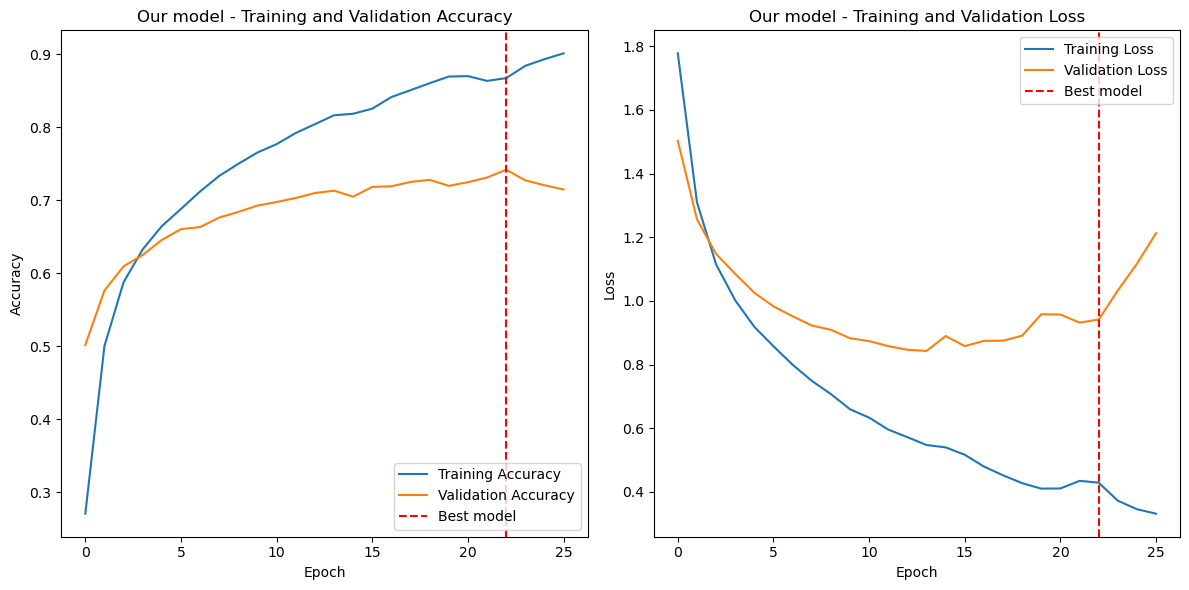

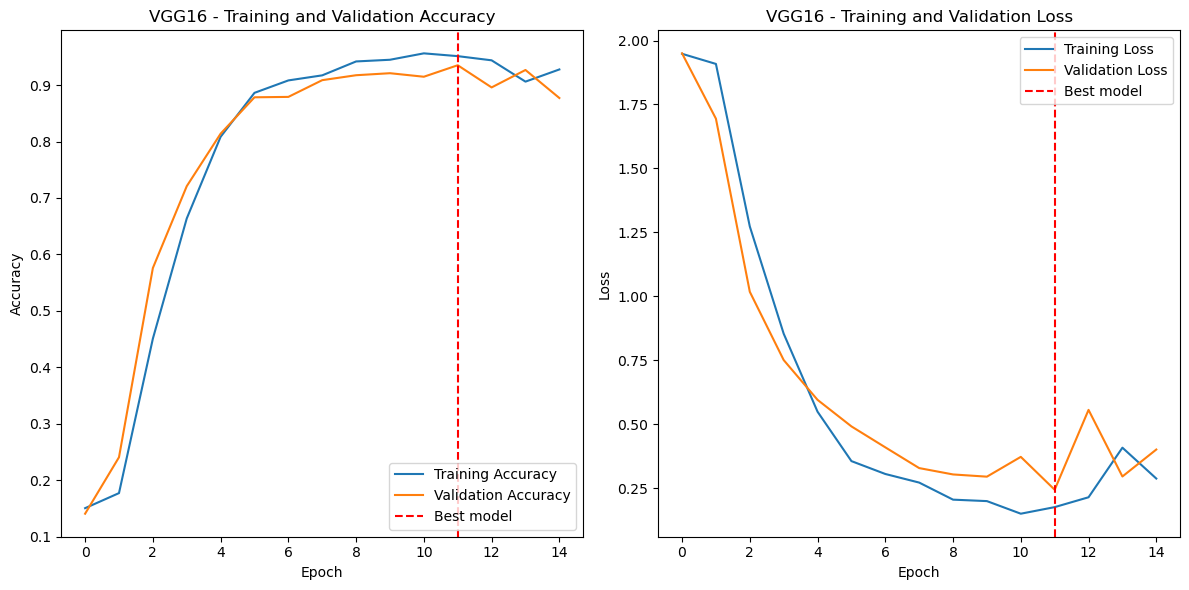

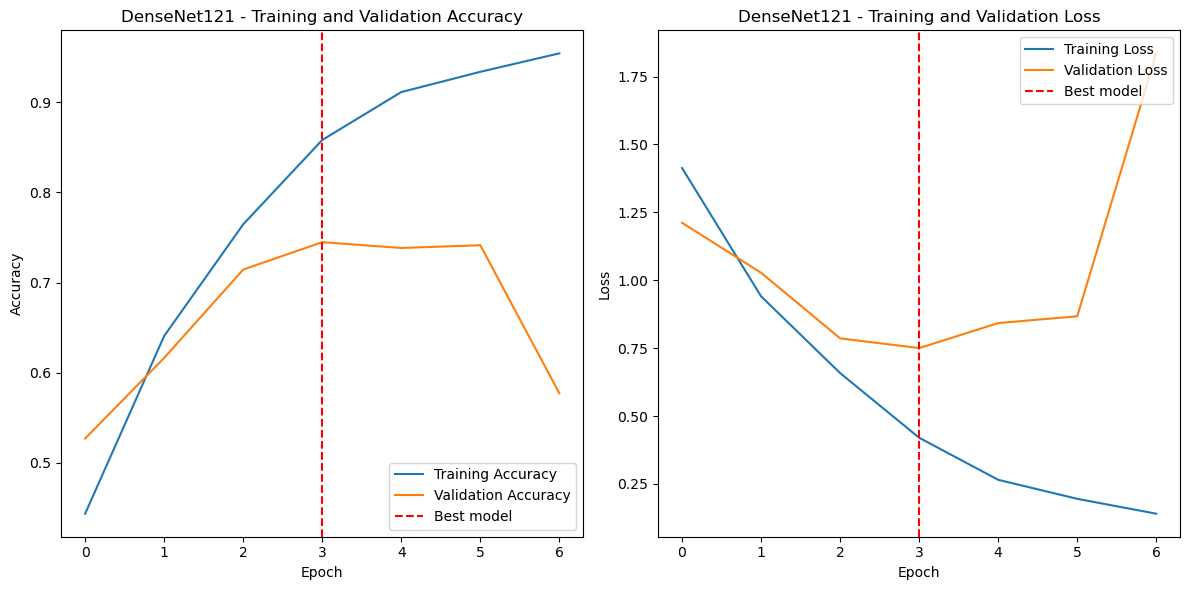

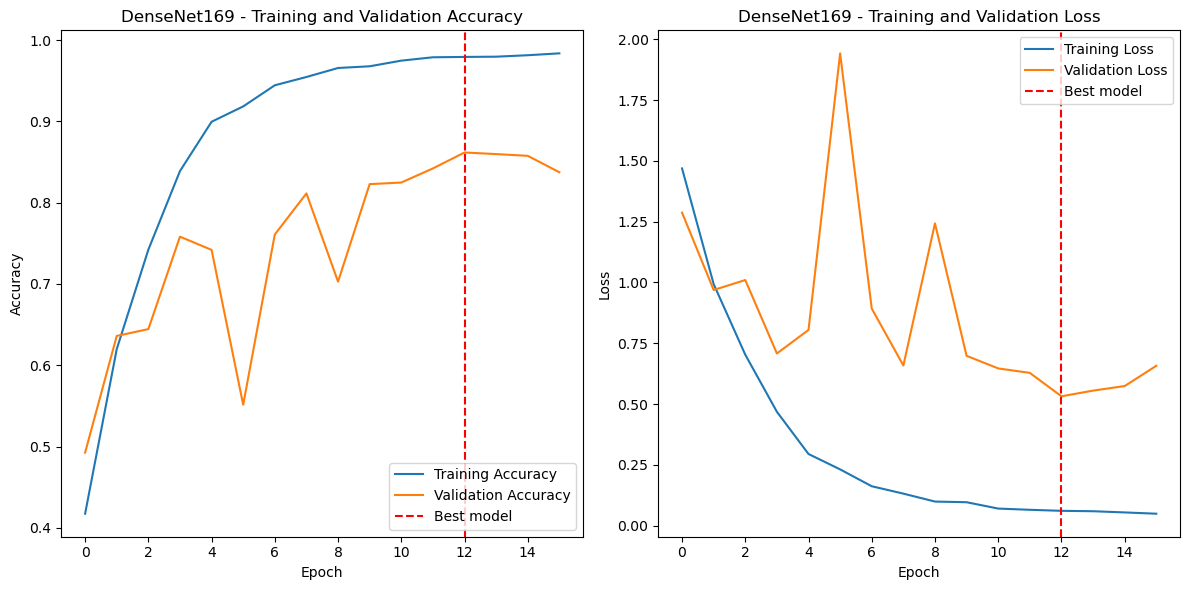

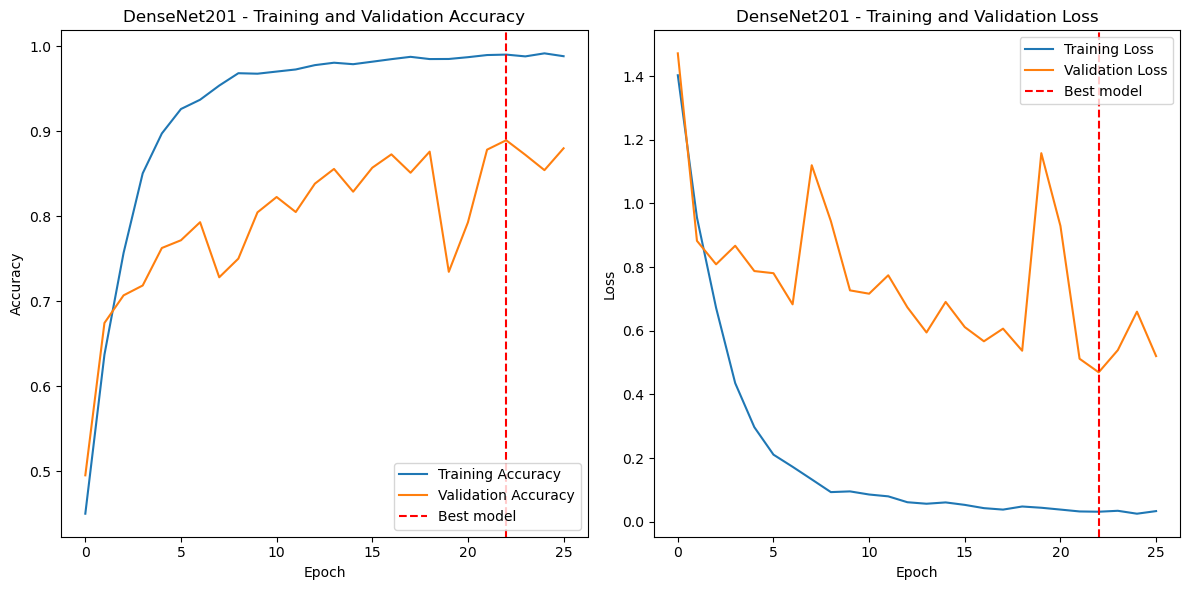

In [13]:
# Generate accuracy and loss plots for each model
for model_name in trained_models:
    history = trained_models[model_name]['history']
    epochs_range = range(len(history['accuracy']))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
    plt.axvline(x=len(history['accuracy']) - 4, color='r', linestyle='--', label='Best model')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.axvline(x=len(history['accuracy']) - 4, color='r', linestyle='--', label='Best model')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()


In [14]:
# Load DataFrame with results
results_df = pd.read_csv("./csv/trained_models_results.csv", index_col=0, usecols=[0, 2, 3, 4, 5, 6, 7])
results_df

,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,test_loss
Our model,0.901313,0.714821,0.744048,0.331795,1.213072,0.934058
VGG16,0.927731,0.877143,0.933631,0.287235,0.400679,0.243861
DenseNet121,0.954307,0.577143,0.749702,0.140244,1.835462,0.725825
DenseNet169,0.983771,0.837500,0.849405,0.048887,0.657109,0.591507
DenseNet201,0.988183,0.879821,0.876786,0.033400,0.520418,0.495406


In [15]:
# Sort the DataFrame by test accuracy
results_df.sort_values(by=['test_accuracy'], ascending=False, inplace=True)

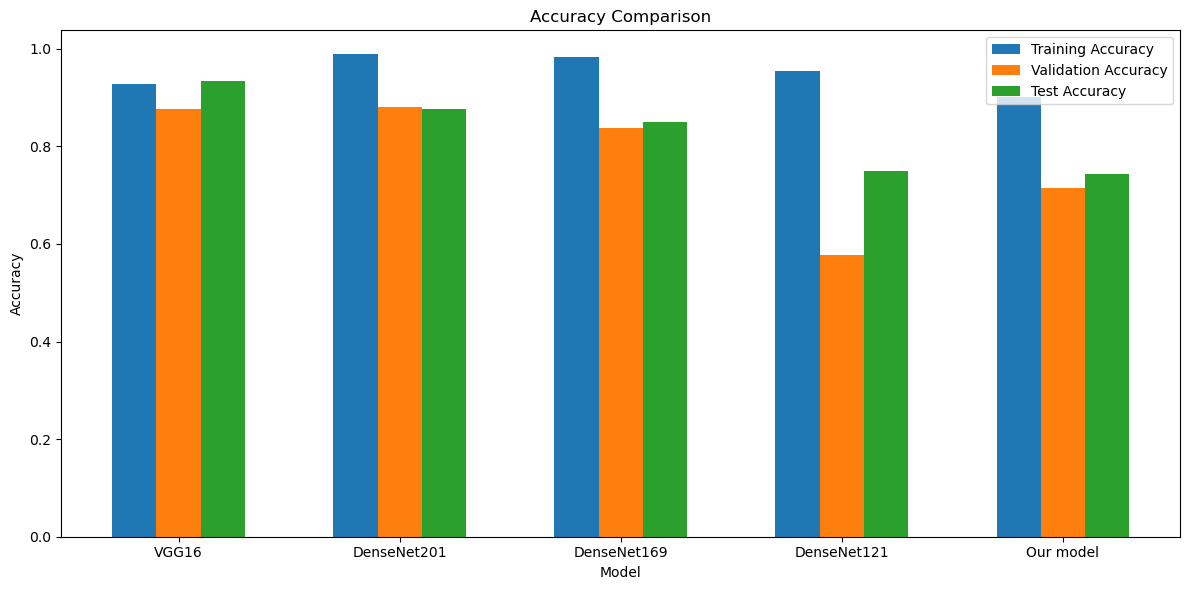

In [16]:
# Create a list of model names
models_list = results_df.index.tolist()

# Compare the accuracy of the models
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(models_list))

plt.bar(index, results_df['train_accuracy'], bar_width, label='Training Accuracy')
plt.bar(index + bar_width, results_df['val_accuracy'], bar_width, label='Validation Accuracy')
plt.bar(index + 2 * bar_width, results_df['test_accuracy'], bar_width, label='Test Accuracy')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(index + bar_width, models_list)
plt.legend()
plt.tight_layout()
plt.show()

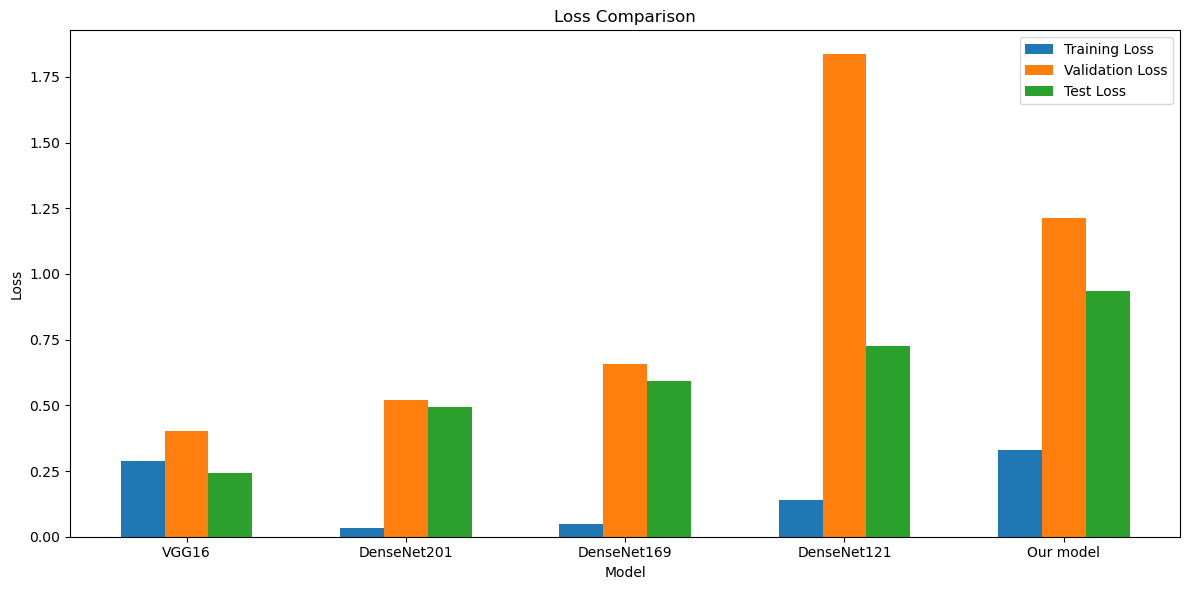

In [17]:
# Compare the loss of the models
plt.figure(figsize=(12, 6))

plt.bar(index, results_df['train_loss'], bar_width, label='Training Loss')
plt.bar(index + bar_width, results_df['val_loss'], bar_width, label='Validation Loss')
plt.bar(index + 2 * bar_width, results_df['test_loss'], bar_width, label='Test Loss')

plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.xticks(index + bar_width, models_list)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# Load the best model
best_model = tf.keras.models.load_model('./best/best_model_VGG16.h5')
our_model = tf.keras.models.load_model('./best/best_model_Our model.h5')

In [19]:
for s in [train_ds, val_ds, test_ds]:

    # Get labels from the test dataset
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)

    # Perform predictions on the test dataset
    predictions = best_model.predict(test_ds)
    predicted_labels = np.argmax(predictions, axis=1)

    # Get class names
    class_names = classes

    # Generate classification report with class names
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(f"\nClassification Report: {'Train' if s == train_ds else 'Validation' if s == val_ds else 'Test'}")
    print(report)

105/105 [==============================] - 3s 28ms/step

Classification Report: Train
              precision    recall  f1-score   support

        3700       0.93      0.93      0.93       476
       32607       0.91      0.91      0.91       484
        2420       0.92      0.94      0.93       485
        6536       0.87      0.88      0.88       468
        3032       1.00      0.98      0.99       499
        2450       0.99      0.96      0.97       476
       99207       0.90      0.93      0.92       472

    accuracy                           0.93      3360
   macro avg       0.93      0.93      0.93      3360
weighted avg       0.93      0.93      0.93      3360

105/105 [==============================] - 3s 29ms/step

Classification Report: Validation
              precision    recall  f1-score   support

        3700       0.93      0.93      0.93       476
       32607       0.91      0.91      0.91       484
        2420       0.92      0.94      0.93       485
        6

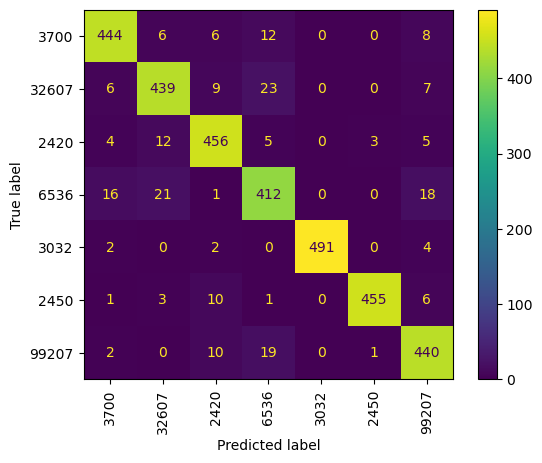

In [20]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(xticks_rotation="vertical")
plt.grid(False)

In [63]:
def load_class_labels_from_csv(csv_file):
    class_labels = {}
    with open(csv_file, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header row
        for row in reader:
            class_index = int(row[0])
            class_name = row[1].strip()  # Remove leading/trailing spaces

            # Check if the class_name is a list, if so, convert it to a string
            if isinstance(class_name, list):
                class_name = ''.join(class_name)

            class_labels[class_index] = class_name

    return class_labels

def preprocess_custom_input(img_path):
    img = image.load_img(img_path, target_size=(64, 64)) 
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_batch

    return img_preprocessed

def classify_with_custom_model(img_path, model, class_labels_file):
    # Load class labels from the CSV file
    class_labels = load_class_labels_from_csv(class_labels_file)

    img_preprocessed = preprocess_custom_input(img_path)

    prediction = model.predict(img_preprocessed)

    # Get the top predicted class and its probability
    class_index = np.argmax(prediction[0])
    probability = prediction[0][class_index]

    class_name = class_labels[class_index]

    print(f"{class_name}: {probability}")

In [61]:
img_path = "./lego_parts/3700/0.jpg"
classify_with_custom_model(img_path, best_model, 'class_mapping.csv')

1/1 [==============================] - 0s 13ms/step
3700: 0.9999994039535522


In [62]:
img_path = "./lego_parts/3700/0.jpg"
classify_with_custom_model(img_path, our_model, 'class_mapping.csv')

1/1 [==============================] - 0s 177ms/step
3700: 0.9804184436798096
